In [158]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns 
import ast

In [ ]:
# # remove runs 

# remove = ["direct_prompt", "self_consistency", "chain_of_thought"]

# pd.read_csv("results.csv").drop(columns=remove).to_csv("results.csv", index=False)

In [165]:
df = pd.read_csv("icc-2023-2025_results.csv")
df = df[~(df['metric'].str.contains('ranking') | df['metric'].str.contains('pvalue'))]
df.drop(columns=["dataset"], inplace=True)
print(df.to_latex())

\begin{tabular}{lllllllll}
\toprule
 & metric & elo & glicko & trueskill & bradley_terry & direct_prompt & self_consistency & implicit_chain_of_thought \\
\midrule
0 & kendalltau-tau & 0.611111111111111 & 0.6666666666666666 & 0.611111111111111 & 0.7777777777777778 & 0.6666666666666666 & 0.6666666666666666 & 0.7777777777777778 \\
2 & spearman-rho & 0.8166666666666667 & 0.8333333333333333 & 0.8166666666666667 & 0.9 & 0.8166666666666667 & 0.8166666666666667 & 0.9 \\
4 & top_3_accuracy & 1.0 & 1.0 & 1.0 & 1.0 & 0.6666666666666666 & 0.6666666666666666 & 0.6666666666666666 \\
5 & top_5_accuracy & 1.0 & 1.0 & 1.0 & 1.0 & 0.8 & 0.8 & 1.0 \\
6 & ndcg & 0.9275490376935193 & 0.9283931613605604 & 0.9222079095222108 & 0.9567362968419213 & 0.9480777699628409 & 0.9480777699628409 & 0.9549682140147074 \\
\bottomrule
\end{tabular}



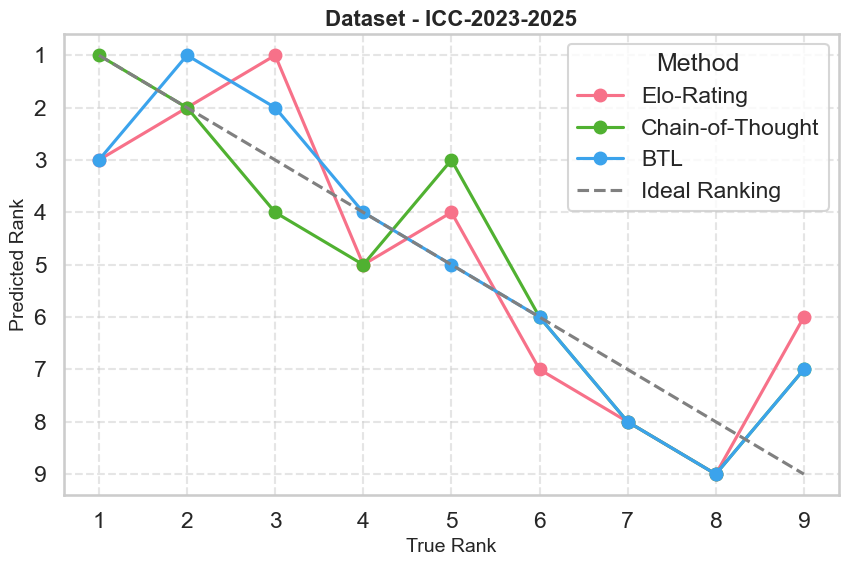

In [157]:
df = pd.read_csv("icc-2023-2025_results.csv")
df = df[(df['metric'].str.contains("ranking"))]

ranking_cols = ['elo', 'implicit_chain_of_thought', 'bradley_terry']

dataset = 'icc-2023-2025'

gold_row = df[(df['dataset'] == dataset) & (df['metric'] == 'gold_ranking')].iloc[0]
gold_ranking = ast.literal_eval(gold_row['elo'])  

teams = list(gold_ranking)
ranking_df = pd.DataFrame({'Team': teams, 'Gold': list(range(1, len(teams)+1))})

for col in ranking_cols:
    method_row = df[(df['dataset'] == dataset) & (df['metric'] == 'predicted_ranking')].iloc[0]
    ranking_list = ast.literal_eval(method_row[col])
    ranking_df[col] = ranking_df['Team'].apply(lambda team: ranking_list.index(team)+1 if team in ranking_list else None)

sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(9, 6))

palette = sns.color_palette("husl", len(ranking_cols))

for idx, col in enumerate(ranking_cols):
    plt.plot(ranking_df['Gold'], ranking_df[col], marker='o', linestyle='-', label="Elo-Rating" if col == "elo" else "Chain-of-Thought" if  col=="implicit_chain_of_thought" else "BTL", color=palette[idx])

plt.plot(ranking_df['Gold'], ranking_df['Gold'], linestyle='--', color='grey', label='Ideal Ranking')

plt.xticks(ticks=range(1, len(ranking_df)+1))
plt.yticks(ticks=range(1, len(ranking_df)+1))
plt.xlabel("True Rank", fontsize=14)
plt.ylabel("Predicted Rank", fontsize=14)
plt.title(f"Dataset - {dataset.upper()}", fontsize=16, fontweight='bold')

plt.gca().invert_yaxis()

plt.legend(title="Method", bbox_to_anchor=(0.65, 0.98), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Ablation -- shuffling

In [166]:
import pandas as pd
not_shuffled = pd.read_csv("icc-2023-2025_results.csv")
not_shuffled.drop(columns=["elo", "glicko", "trueskill", "bradley_terry"], inplace=True)

shuffled = pd.read_csv("icc-2023-2025_shuffled.csv")
shuffled.drop(columns=["explicit_chain_of_thought"], inplace=True)

In [167]:
not_shuffled['shuffled'] = False
shuffled['shuffled'] = True
data = pd.concat([not_shuffled, shuffled], axis=0)

In [180]:
df

,dataset,metric,direct_prompt,self_consistency,implicit_chain_of_thought,shuffled
7,icc-2023-2025,gold_ranking,"['South Africa', 'Australia', 'India', 'New Ze...","['South Africa', 'Australia', 'India', 'New Ze...","['South Africa', 'Australia', 'India', 'New Ze...",False
8,icc-2023-2025,predicted_ranking,"['South Africa', 'England', 'Australia', 'Indi...","['South Africa', 'England', 'Australia', 'Indi...","['South Africa', 'Australia', 'England', 'Indi...",False
7,icc-2023-2025,gold_ranking,"['South Africa', 'Australia', 'India', 'New Ze...","['South Africa', 'Australia', 'India', 'New Ze...","['South Africa', 'Australia', 'India', 'New Ze...",True
8,icc-2023-2025,predicted_ranking,"['Australia', 'South Africa', 'India', 'Englan...","['Australia', 'South Africa', 'India', 'Englan...","['South Africa', 'Australia', 'India', 'Englan...",True


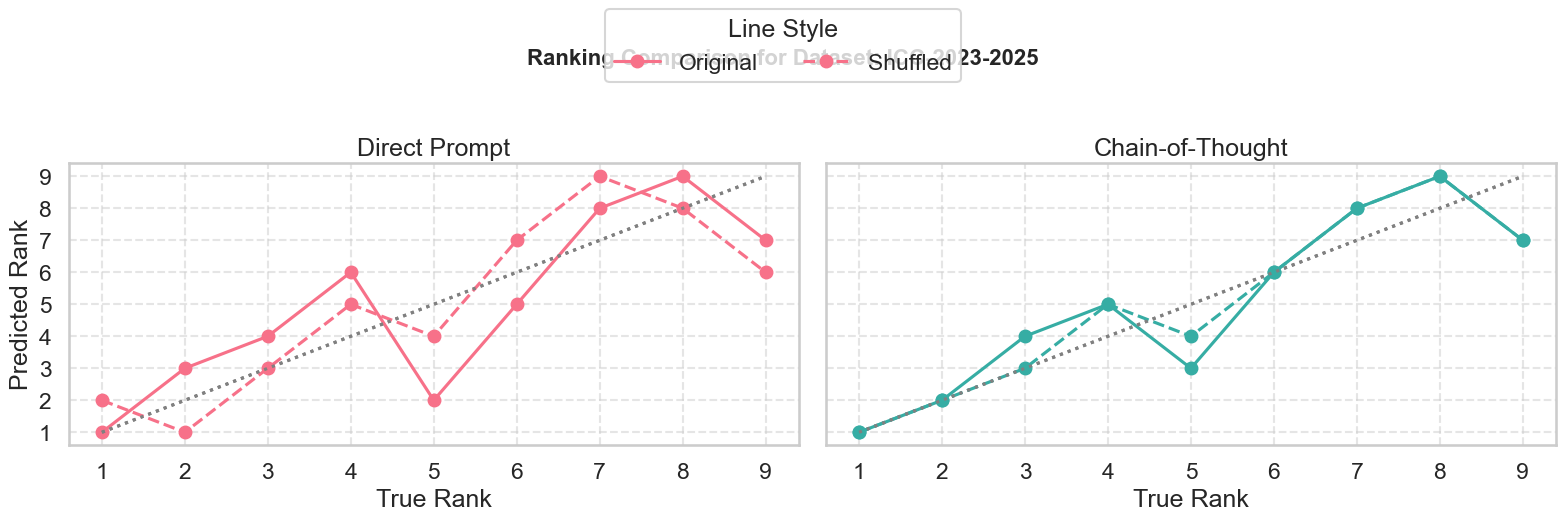

In [72]:
df = pd.DataFrame(data)

df_non_shuffled = df[df['shuffled'] == False].reset_index(drop=True)
df_shuffled = df[df['shuffled'] == True].reset_index(drop=True)

df_combined = pd.concat([df_non_shuffled.set_index('metric')[['direct_prompt', 'self_consistency', 'implicit_chain_of_thought']],
                         df_shuffled.set_index('metric')[['direct_prompt', 'self_consistency', 'implicit_chain_of_thought']]],
                        axis=1, keys=['Non-Shuffled', 'Shuffled'])

styler = df_combined.style

styler = styler.format(precision=3)

# styler = styler.highlight_max(axis=1, props='cellcolor:[HTML]{FFFF00};')

column_format = '|' + '|'.join(['c'] * (df_combined.shape[1] + int(df_combined.index.name is not None))) + '|'

latex_code = styler.to_latex(
    column_format=column_format,
    hrules=True,
    position_float='centering'
)

print(latex_code)


\begin{table}
\centering
\begin{tabular}{|c|c|c|c|c|c|c|}
\toprule
 & \multicolumn{3}{r}{Non-Shuffled} & \multicolumn{3}{r}{Shuffled} \\
 & direct_prompt & self_consistency & implicit_chain_of_thought & direct_prompt & self_consistency & implicit_chain_of_thought \\
metric &  &  &  &  &  &  \\
\midrule
kendalltau-tau & 0.6666666666666666 & 0.6666666666666666 & 0.7777777777777778 & 0.6666666666666666 & 0.6666666666666666 & 0.8333333333333334 \\
kendalltau-pvalue & 0.012665343915343916 & 0.012665343915343916 & 0.0024250440917107582 & 0.012665343915343916 & 0.012665343915343916 & 0.0008542768959435626 \\
spearman-rho & 0.8166666666666667 & 0.8166666666666667 & 0.9 & 0.8499999999999999 & 0.8499999999999999 & 0.9333333333333332 \\
spearman-pvalue & 0.007224785246358785 & 0.007224785246358785 & 0.0009430623223403293 & 0.003704777327585813 & 0.003704777327585813 & 0.00023589981215941676 \\
top_3_accuracy & 0.6666666666666666 & 0.6666666666666666 & 0.6666666666666666 & 1.0 & 1.0 & 1.0 \\
top_5

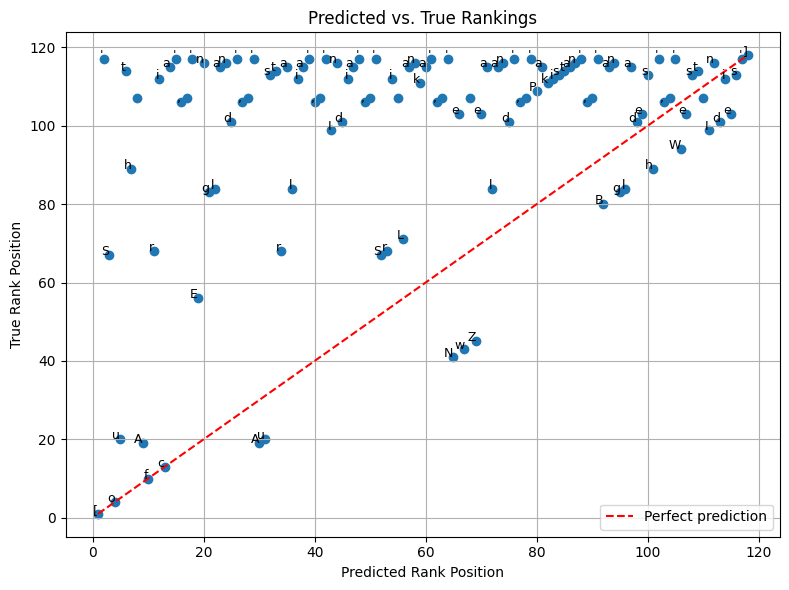

In [75]:
data

,dataset,metric,direct_prompt,self_consistency,implicit_chain_of_thought,shuffled
0,icc-2023-2025,kendalltau-tau,0.6666666666666666,0.6666666666666666,0.7777777777777778,False
1,icc-2023-2025,kendalltau-pvalue,0.012665343915343916,0.012665343915343916,0.0024250440917107582,False
2,icc-2023-2025,spearman-rho,0.8166666666666667,0.8166666666666667,0.9,False
3,icc-2023-2025,spearman-pvalue,0.007224785246358785,0.007224785246358785,0.0009430623223403293,False
4,icc-2023-2025,top_3_accuracy,0.6666666666666666,0.6666666666666666,0.6666666666666666,False
5,icc-2023-2025,top_5_accuracy,0.8,0.8,1.0,False
6,icc-2023-2025,ndcg,0.9480777699628409,0.9480777699628409,0.9549682140147074,False
7,icc-2023-2025,gold_ranking,"['South Africa', 'Australia', 'India', 'New Ze...","['South Africa', 'Australia', 'India', 'New Ze...","['South Africa', 'Australia', 'India', 'New Ze...",False
8,icc-2023-2025,predicted_ranking,"['South Africa', 'England', 'Australia', 'Indi...","['South Africa', 'England', 'Australia', 'Indi...","['South Africa', 'Australia', 'England', 'Indi...",False
0,icc-2023-2025,kendalltau-tau,0.6666666666666666,0.6666666666666666,0.8333333333333334,True


## NFL - Scores

In [108]:
years = [2018, 2019, 2020, 2021, 2022, 2023]

dfs = []

for year in years:
    df = pd.read_csv(f"nfl-{year}_results.csv")
    if "self_consistency" in df.columns:
        df.drop(columns=["self_consistency"], inplace=True)
    df = df[(df['metric'].str.contains("ndcg"))]
    
    # df['year'] = year
    
    dfs.append(df)

combined_data = pd.concat(dfs, ignore_index=True)

combined_data = combined_data.drop_duplicates().reset_index(drop=True)

In [86]:
print(combined_data.to_latex())

\begin{tabular}{lllllllll}
\toprule
 & dataset & metric & elo & glicko & trueskill & bradley_terry & direct_prompt & implicit_chain_of_thought \\
\midrule
0 & nfl-2018 & ndcg & 0.9375296467323766 & 0.8776762439483653 & 0.8141065354280506 & 0.8522228482107301 & 0.858059783001187 & 0.8159654811402812 \\
1 & nfl-2019 & ndcg & 0.8032093253794107 & 0.8544864350583276 & 0.857341491794788 & 0.889261848778121 & 0.8515051383900618 & 0.8038095814152922 \\
2 & nfl-2020 & ndcg & 0.8963049415192319 & 0.8898121890490458 & 0.8574537862805353 & 0.9117802942460322 & 0.8464218353836012 & 0.897389894092824 \\
3 & nfl-2021 & ndcg & 0.7537431876481697 & 0.741106287262618 & 0.7412262935991849 & 0.7502325606268836 & 0.8510839519295962 & 0.8798589874178397 \\
4 & nfl-2022 & ndcg & 0.8475610634543458 & 0.8283462404913987 & 0.8394383083792455 & 0.7991745549660138 & 0.7692847764049486 & 0.7945884736035103 \\
5 & nfl-2023 & ndcg & 0.9146885028805 & 0.8985590402452742 & 0.9026400000507226 & 0.9075714620441837 & 0.

In [109]:
combined_data

,dataset,metric,elo,glicko,trueskill,bradley_terry,direct_prompt,implicit_chain_of_thought
0,nfl-2018,ndcg,0.9375296467323766,0.8776762439483653,0.8141065354280506,0.8522228482107301,0.858059783001187,0.8159654811402812
1,nfl-2019,ndcg,0.8032093253794107,0.8544864350583276,0.857341491794788,0.889261848778121,0.8515051383900618,0.8038095814152922
2,nfl-2020,ndcg,0.8963049415192319,0.8898121890490458,0.8574537862805353,0.9117802942460322,0.8464218353836012,0.897389894092824
3,nfl-2021,ndcg,0.7537431876481697,0.741106287262618,0.7412262935991849,0.7502325606268836,0.8510839519295962,0.8798589874178397
4,nfl-2022,ndcg,0.8475610634543458,0.8283462404913987,0.8394383083792455,0.7991745549660138,0.7692847764049486,0.7945884736035103
5,nfl-2023,ndcg,0.9146885028805,0.8985590402452742,0.9026400000507226,0.9075714620441837,0.8128298471637568,0.8767735253135754


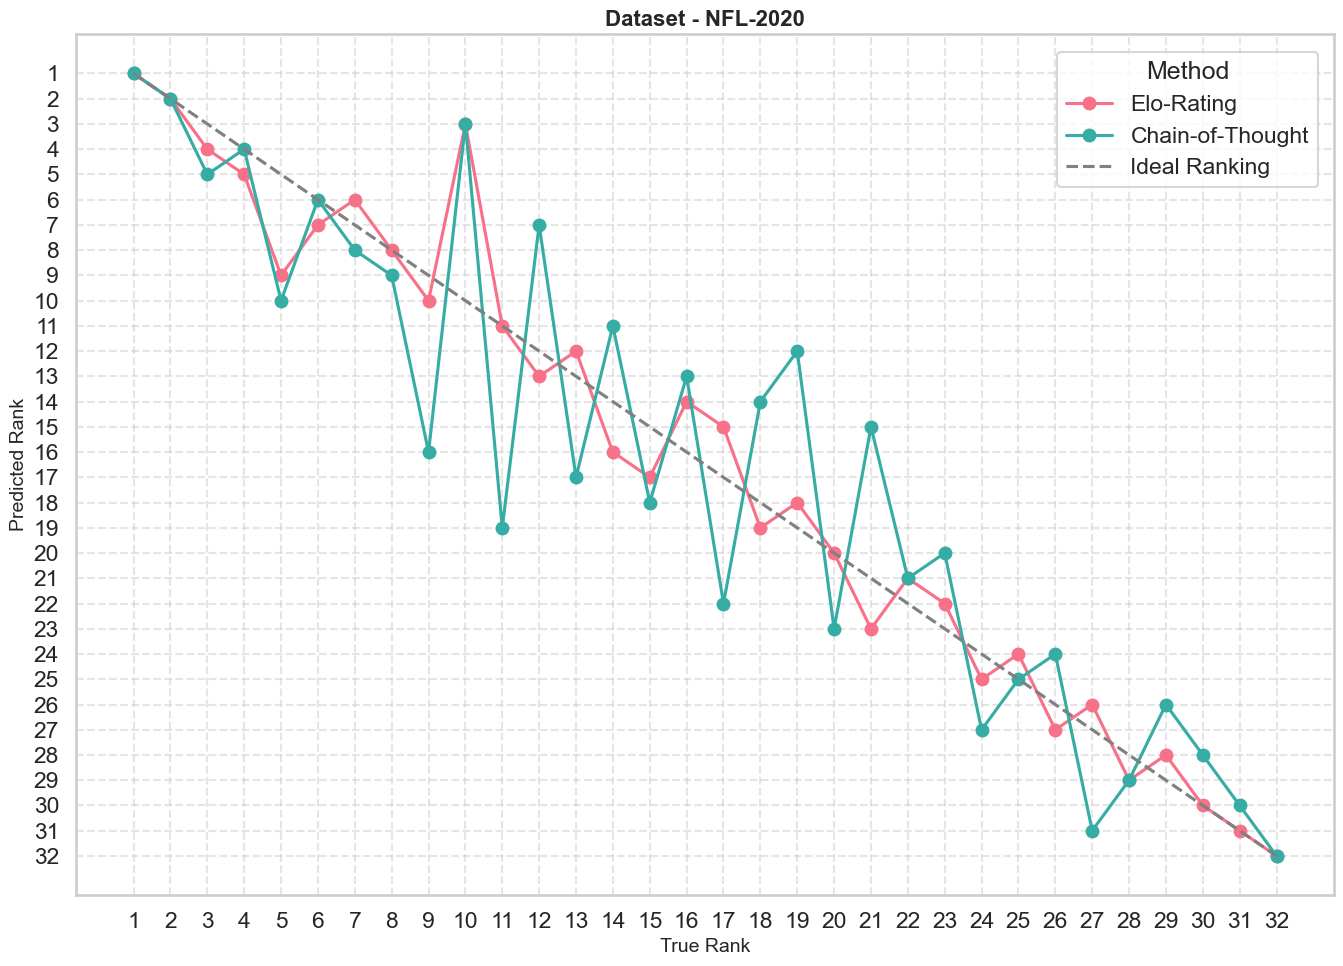

In [143]:
import ast 

df = pd.read_csv("nfl-2020_results.csv")
df = df[(df['metric'].str.contains("ranking"))]

ranking_cols = ['elo', 'implicit_chain_of_thought']

dataset = 'nfl-2020'

gold_row = df[(df['dataset'] == dataset) & (df['metric'] == 'gold_ranking')].iloc[0]
gold_ranking = ast.literal_eval(gold_row['elo'])  

teams = list(gold_ranking)
ranking_df = pd.DataFrame({'Team': teams, 'Gold': list(range(1, len(teams)+1))})

for col in ranking_cols:
    method_row = df[(df['dataset'] == dataset) & (df['metric'] == 'predicted_ranking')].iloc[0]
    ranking_list = ast.literal_eval(method_row[col])
    ranking_df[col] = ranking_df['Team'].apply(lambda team: ranking_list.index(team)+1 if team in ranking_list else None)

sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(14, 10))

palette = sns.color_palette("husl", len(ranking_cols))

for idx, col in enumerate(ranking_cols):
    plt.plot(ranking_df['Gold'], ranking_df[col], marker='o', linestyle='-', label="Elo-Rating" if col == "elo" else "Chain-of-Thought", color=palette[idx])

plt.plot(ranking_df['Gold'], ranking_df['Gold'], linestyle='--', color='grey', label='Ideal Ranking')

plt.xticks(ticks=range(1, len(ranking_df)+1))
plt.yticks(ticks=range(1, len(ranking_df)+1))
plt.xlabel("True Rank", fontsize=14)
plt.ylabel("Predicted Rank", fontsize=14)
plt.title(f"Dataset - {dataset.upper()}", fontsize=16, fontweight='bold')

plt.gca().invert_yaxis()

plt.legend(title="Method", bbox_to_anchor=(0.78, 0.98), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

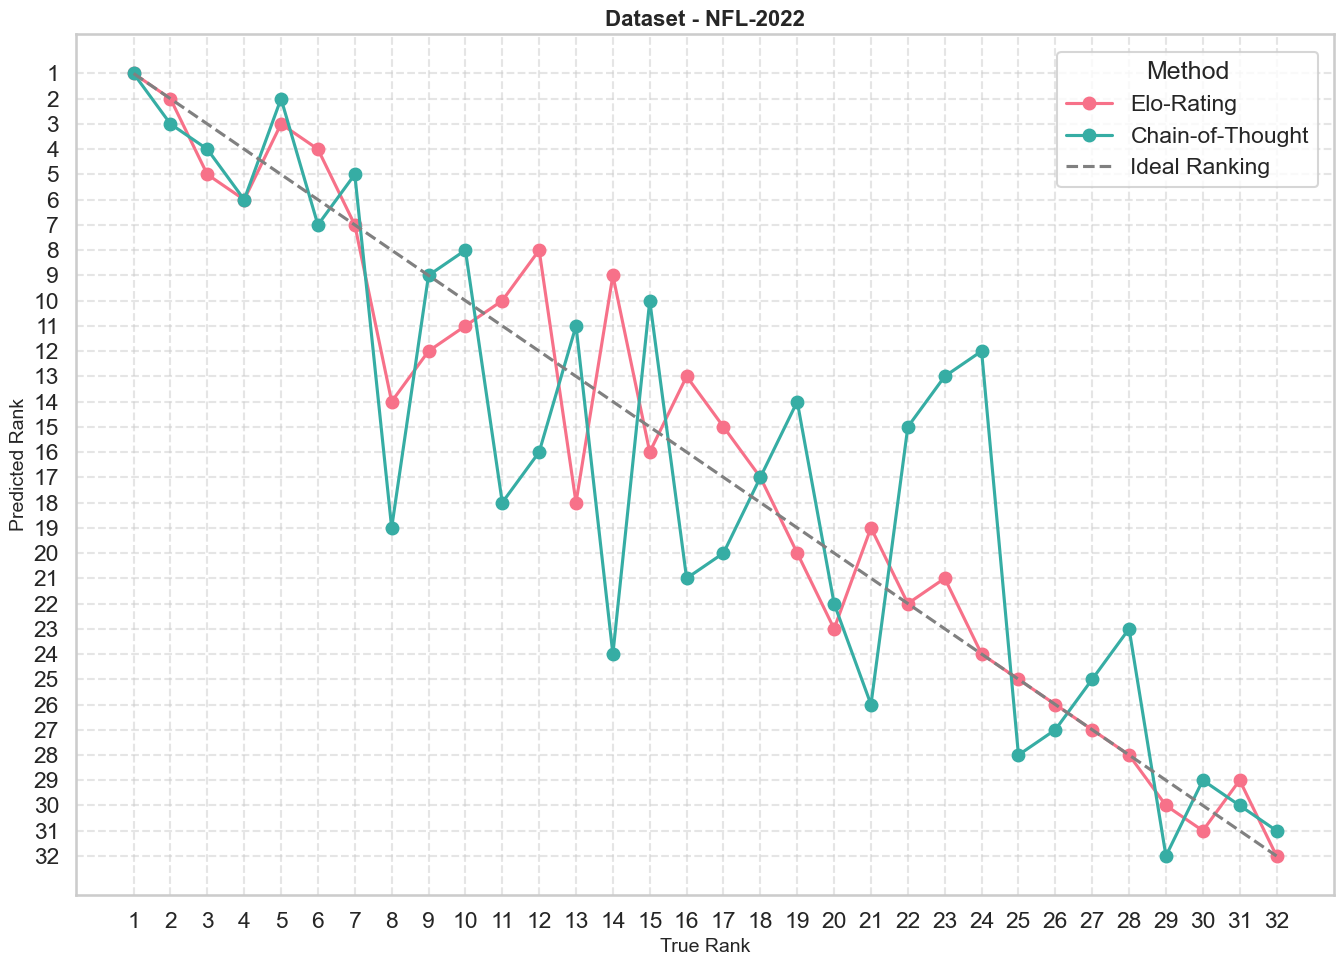

In [145]:
import ast 

df = pd.read_csv("nfl-2022_results.csv")
df = df[(df['metric'].str.contains("ranking"))]

ranking_cols = ['elo', 'implicit_chain_of_thought']

dataset = 'nfl-2022'

gold_row = df[(df['dataset'] == dataset) & (df['metric'] == 'gold_ranking')].iloc[0]
gold_ranking = ast.literal_eval(gold_row['elo'])  

teams = list(gold_ranking)
ranking_df = pd.DataFrame({'Team': teams, 'Gold': list(range(1, len(teams)+1))})

for col in ranking_cols:
    method_row = df[(df['dataset'] == dataset) & (df['metric'] == 'predicted_ranking')].iloc[0]
    ranking_list = ast.literal_eval(method_row[col])
    ranking_df[col] = ranking_df['Team'].apply(lambda team: ranking_list.index(team)+1 if team in ranking_list else None)

sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(14, 10))

palette = sns.color_palette("husl", len(ranking_cols))

for idx, col in enumerate(ranking_cols):
    plt.plot(ranking_df['Gold'], ranking_df[col], marker='o', linestyle='-', label="Elo-Rating" if col == "elo" else "Chain-of-Thought", color=palette[idx])

plt.plot(ranking_df['Gold'], ranking_df['Gold'], linestyle='--', color='grey', label='Ideal Ranking')

plt.xticks(ticks=range(1, len(ranking_df)+1))
plt.yticks(ticks=range(1, len(ranking_df)+1))
plt.xlabel("True Rank", fontsize=14)
plt.ylabel("Predicted Rank", fontsize=14)
plt.title(f"Dataset - {dataset.upper()}", fontsize=16, fontweight='bold')

plt.gca().invert_yaxis()

plt.legend(title="Method", bbox_to_anchor=(0.78, 0.98), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Log shuffled on NFL

In [105]:
years = [2018, 2019, 2020, 2021, 2022, 2023]

dfs = []
shuffled_dfs = []

for year in years:
    df = pd.read_csv(f"nfl-{year}_results.csv")
    df.drop(columns=[col for col in df.columns if col not in ["dataset", "metric", "direct_prompt", "implicit_chain_of_thought"]], inplace=True)
    df = df[(df['metric'].str.contains("ndcg") | df['metric'].str.contains("tau-tau"))]
    
    # df['year'] = year
    df['shuffled'] = False
    
    dfs.append(df)
    
    shuffled_df = pd.read_csv(f"nfl-{year}_shuffled.csv")
    if "self_consistency" in shuffled_df.columns:
        shuffled_df.drop(columns=[col for col in df.columns if col not in ["dataset", "metric", "direct_prompt", "implicit_chain_of_thought"]], inplace=True)
    shuffled_df = shuffled_df[(shuffled_df['metric'].str.contains("ndcg") | shuffled_df['metric'].str.contains("tau-tau"))]
    
    # shuffled_df['year'] = year
    shuffled_df['shuffled'] =  True
    
    shuffled_dfs.append(shuffled_df)

combined_data = pd.concat(dfs+shuffled_dfs, ignore_index=True)

combined_data = combined_data.drop_duplicates().reset_index(drop=True)

In [106]:
combined_data

,dataset,metric,direct_prompt,implicit_chain_of_thought,shuffled
0,nfl-2018,kendalltau-tau,0.10080645161290325,0.040322580645161296,False
1,nfl-2018,ndcg,0.858059783001187,0.8159654811402812,False
2,nfl-2019,kendalltau-tau,0.0,-0.12096774193548389,False
3,nfl-2019,ndcg,0.8515051383900618,0.8038095814152922,False
4,nfl-2020,kendalltau-tau,0.14112903225806453,0.1532258064516129,False
5,nfl-2020,ndcg,0.8464218353836012,0.897389894092824,False
6,nfl-2021,kendalltau-tau,0.028225806451612906,0.14919354838709678,False
7,nfl-2021,ndcg,0.8510839519295962,0.8798589874178397,False
8,nfl-2022,kendalltau-tau,-0.12096774193548389,-0.020161290322580648,False
9,nfl-2022,ndcg,0.7692847764049486,0.7945884736035103,False


In [107]:
df = pd.DataFrame(combined_data)

df_non_shuffled = df[df['shuffled'] == False].reset_index(drop=True)
df_shuffled = df[df['shuffled'] == True].reset_index(drop=True)

df_combined = pd.concat([df_non_shuffled.set_index(['dataset', 'metric'])[['direct_prompt', 'implicit_chain_of_thought']],
                         df_shuffled.set_index(['dataset', 'metric'])[['direct_prompt', 'implicit_chain_of_thought']]],
                        axis=1, keys=['Non-Shuffled', 'Shuffled'])

print(df_combined.to_latex())

\begin{tabular}{llllll}
\toprule
 &  & \multicolumn{2}{r}{Non-Shuffled} & \multicolumn{2}{r}{Shuffled} \\
 &  & direct_prompt & implicit_chain_of_thought & direct_prompt & implicit_chain_of_thought \\
dataset & metric &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{nfl-2018} & kendalltau-tau & 0.10080645161290325 & 0.040322580645161296 & 0.048387096774193554 & 0.11290322580645162 \\
 & ndcg & 0.858059783001187 & 0.8159654811402812 & 0.817238648087025 & 0.8064011621573609 \\
\cline{1-6}
\multirow[t]{2}{*}{nfl-2019} & kendalltau-tau & 0.0 & -0.12096774193548389 & -0.060483870967741944 & -0.00403225806451613 \\
 & ndcg & 0.8515051383900618 & 0.8038095814152922 & 0.8096816542614863 & 0.8582489296368566 \\
\cline{1-6}
\multirow[t]{2}{*}{nfl-2020} & kendalltau-tau & 0.14112903225806453 & 0.1532258064516129 & -0.07258064516129033 & -0.12903225806451615 \\
 & ndcg & 0.8464218353836012 & 0.897389894092824 & 0.8152865264074878 & 0.7542720893940046 \\
\cline{1-6}
\multirow[t]{2}{*}{nfl-2021} & kendall

In [104]:
df_combined

Non-Shuffled  \
                                                                     direct_prompt   
dataset       metric                                                                 
icc-2023-2025 kendalltau-tau                                    0.6666666666666666   
              kendalltau-pvalue                               0.012665343915343916   
              spearman-rho                                      0.8166666666666667   
              spearman-pvalue                                 0.007224785246358785   
              top_3_accuracy                                    0.6666666666666666   
              top_5_accuracy                                                   0.8   
              ndcg                                              0.9480777699628409   
              gold_ranking       ['South Africa', 'Australia', 'India', 'New Ze...   
              predicted_ranking  ['South Africa', 'England', 'Australia', 'Indi...   

                                                                                    \
                                                         implicit_chain_of_thought   
dataset       metric                                                                 
icc-2023-2025 kendalltau-tau                                    0.7777777777777778   
              kendalltau-pvalue                              0.0024250440917107582   
              spearman-rho                                                     0.9   
              spearman-pvalue                                0.0009430623223403293   
              top_3_accuracy                                    0.6666666666666666   
              top_5_accuracy                                                   1.0   
              ndcg                                              0.9549682140147074   
              gold_ranking       ['South Africa', 'Australia', 'India', 'New Ze...   
              predicted_ranking  ['South Africa', 'Australia', 'England', 'Indi...   

                                                                          Shuffled  \
                                                                     direct_prompt   
dataset       metric                                                                 
icc-2023-2025 kendalltau-tau                                    0.6666666666666666   
              kendalltau-pvalue                               0.012665343915343916   
              spearman-rho                                      0.8499999999999999   
              spearman-pvalue                                 0.003704777327585813   
              top_3_accuracy                                                   1.0   
              top_5_accuracy                                                   1.0   
              ndcg                                              0.9237339513366495   
              gold_ranking       ['South Africa', 'Australia', 'India', 'New Ze...   
              predicted_ranking  ['Australia', 'South Africa', 'India', 'Englan...   

                                                                                    
                                                         implicit_chain_of_thought  
dataset       metric                                                                
icc-2023-2025 kendalltau-tau                                    0.8333333333333334  
              kendalltau-pvalue                              0.0008542768959435626  
              spearman-rho                                      0.9333333333333332  
              spearman-pvalue                               0.00023589981215941676  
              top_3_accuracy                                                   1.0  
              top_5_accuracy                                                   1.0  
              ndcg                                              0.9574965272155285  
              gold_ranking       ['South Africa', 'Australia', 'India', 'New Ze...  
              predicted_ranking  ['S